# Hate Speech Detection Model Implementation

## Import relevant libraries

In [ ]:
#!pip install -U gensim

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import string
# 
import nltk.corpus
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')         
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import genism
from gensim.models import Word2Vec, FastText
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
#
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.initializers import Constant

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\c2058594\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\c2058594\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c2058594\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\c2058594\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\c2058594\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\c2058594\Anaconda3\envs\tensorflow_env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshte

## Import Trainging, Test and Validation data

In [2]:
columns = ['id','text','HS','TR','AG']
df_test= pd.read_csv("test_en.tsv",sep="\t",header=None,names = columns)
df_train= pd.read_csv("train_en.tsv",sep="\t",header=0,names = columns)
df_validation= pd.read_csv("dev_en.tsv",sep="\t",header=0,names = columns)
lemmatizer = WordNetLemmatizer()

# Data Preprocessing

Following processing are done :
1. Convert to lower case
2. Remove URLs, HTML Reference characters, numbers and mentions.
3. Tokenize using NLTK Tweet tokenizer 
4. Remove punctuations and stop words.
5. Lemmatize  words based on part of speech tag

In [3]:
def preprocess_data(data_set):
    '''
    This function performs data pre-processing and the processed tweets are added as a new column 'cleaned_tweets' in the dataframe.
    input - Dataset to be processed as pandas dataframe
    output - Update Dataset
    '''
# Make a copy of the dataset before pre-processing
    df = data_set.copy()
# Convert text to lower case
    df['cleaned_tweets'] = df.text.str.lower()
# Remove URLs
    df['cleaned_tweets'] = df['cleaned_tweets'].str.replace('https?:\/\/\S+', '')   
# Remove HTML reference characters (&[a-z];)
    df['cleaned_tweets'] = df['cleaned_tweets'].str.replace('&[a-z]+;', '')   
# It is not ideal to keep real names for data analysis as it might be against Data Ethics, Hence we will try
# to anoymize the data by removing the mentions.
    df['cleaned_tweets'] = df['cleaned_tweets'].str.replace('@[a-z]+', '') 
# Remove numbers as they do not provide any insights.   
    df['cleaned_tweets'] = df['cleaned_tweets'].str.replace('\d+', '') 
#    
# Before performing punctuation removal and stop words removal, we will tokenize the tweets    
# using NLTK tweet tokenizer, By using 'tweet tokenizer', emojis and hashtags can be kept together.
# This makes sure 'emoticons like - :-)' are preserved which would have been otherwise removed by punctuation removal 
# process.
    tknzr = TweetTokenizer()
    df['tokens'] = df['cleaned_tweets'].apply(tknzr.tokenize)  
# Add punctuations along with stopwords..
    punctuations = string.punctuation
    sw = set(stopwords.words('english')) 
    sw.add('...')
    sw.add('’')
    sw.add('“')
    sw.add('”')
    sw.remove('not')
    for punctuation in punctuations: 
        sw.add(punctuation)
# Remove punctuations and stopwords.
    df['tokens'] = df['tokens'].apply(lambda x: [item for item in x if item not in sw]) 
# Lemmatize  words based on part of speech tag for each word.
    df['tokens'] = df['tokens'].apply(lemmatize_words)
# Update cleaned_text with lemma form of words.        
    df['cleaned_tweets'] = df['tokens'].apply(lambda x : ' '.join(x))   
    return df

In [4]:
def lemmatize_words(tokens):
    """
    Lemmatizer function based on an nltk lemmatizer object. 
    The words are lemmatized based on part of speech tag.
    
    Params:
    tokens: list of tokens for each tweet
    """
    tagged = pos_tag(tokens)
    lemmatized_toks = []
    for tok,pos in tagged:
        pos_first = pos[0].lower()
        if pos_first in 'n v'.split():
            lemma=lemmatizer.lemmatize(tok,pos_first)
        else:
            lemma=tok
        lemmatized_toks.append(lemma)
    return lemmatized_toks

In [5]:
# Pre-process training data
train = preprocess_data(df_train)
# Pre-process the test data 
test = preprocess_data(df_test)
# Pre-process the validation data
val = preprocess_data(df_validation)

In [6]:
train.head()

,id,text,HS,TR,AG,cleaned_tweets,tokens
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0,hurray save us many way #lockthemup #buildthew...,"[hurray, save, us, many, way, #lockthemup, #bu..."
1,202,Why would young fighting age men be the vast m...,1,0,0,would young fight age men vast majority one es...,"[would, young, fight, age, men, vast, majority..."
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0,illegals dump kid border like road kill refuse...,"[illegals, dump, kid, border, like, road, kill..."
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0,ny time nearly white state pose array problem ...,"[ny, time, nearly, white, state, pose, array, ..."
4,205,Orban in Brussels: European leaders are ignori...,0,0,0,orban brussels european leader ignore people n...,"[orban, brussels, european, leader, ignore, pe..."


## Split the datasets into inputs and target


In [7]:
#split the x_train, x_test, y_train, y_test, x_val, y_val
x_train = train.cleaned_tweets.values
y_train = train.HS.values

x_test=test.cleaned_tweets.values
y_test = test.HS.values

x_val = val.cleaned_tweets.values
y_val = val.HS.values

# Transfer Learning with GloVe Word Vectors


In [8]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [9]:
# Get the GloVe pre-trained word vectors downloaded from https://nlp.stanford.edu/projects/glove/
word_to_vec_map = read_glove_vector('glove.twitter.27B.200d.txt')

In [10]:
# load the 200 dimensional word vector in the appropriate format for the genism Word2Vec library.
# 200 dimension vector gave better results than other dimension vectors.
glove_file = datapath('C:/Users/c2058594/Downloads/CMT307 Group Coursework/hate_speech/Model/glove.twitter.27B.200d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")
# 'glove2word2vec' script convert GloVe vectors into the word2vec format. Both Glove and Word2Vec files are presented in text format 
# and almost identical except that word2vec includes number of vectors.
_ = glove2word2vec(glove_file, tmp_file)
# 'KeyedVectors' creates a mapping between key and vectors. Each vector can be identified by its lookup key.
glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)

C:\Users\c2058594\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  """


In [11]:
from gensim.models import Word2Vec
# Vector size for each word
word_size = 200
# build word2vec model on the training dataset
model_wv = Word2Vec(vector_size=200, window=20)
model_wv.build_vocab(list(train.tokens))
total_examples = model_wv.corpus_count

## Add GloVe Weights and retrain the word2vec model

In [14]:
# add GloVe vocabulary & weights
model_wv.build_vocab([glove_vectors.index_to_key], update=True)

# train the model. This gives a new set of word vectors that uses GloVe weights but tuned to incorporate training data.
model_wv.train(list(train.tokens), total_examples=total_examples, epochs=model_wv.epochs)
base_model_wv = model_wv.wv

## Encode each tweet as a sequence of integers.

This needs to be done since Keras Embedding layer requires integer inputs.

In [15]:
# create the tokenizer
tokenizer_obj = Tokenizer()
# fit the tokenizer on the training input data
tokenizer_obj.fit_on_texts(x_train)

In [16]:
# Encode the tweets in the training dataset
X_train_tokens = tokenizer_obj.texts_to_sequences(x_train)
# Encode the tweets in the test dataset
X_test_tokens = tokenizer_obj.texts_to_sequences(x_test)
# Encode the tweets in the validation dataset
X_dev_tokens = tokenizer_obj.texts_to_sequences(x_val)

In [17]:
# Pad all tweets (training, test and validation) to the length of the longest review in the training dataset.
max_length = max([len(s.split()) for s in x_train])
X_train_pad = pad_sequences(X_train_tokens, maxlen = max_length, padding = 'post')
X_test_pad = pad_sequences(X_test_tokens, maxlen = max_length, padding = 'post')
X_dev_pad = pad_sequences(X_dev_tokens, maxlen = max_length, padding = 'post')

In [18]:
# define vocabulary size
num_words = len(tokenizer_obj.word_index) + 1
# define Embedding weight matrix dimensions with all 0
embedding_matrix = np.zeros((num_words, 200))
# Create embedding layer such that the encoded words map to the correct vector.
for word, i in tokenizer_obj.word_index.items():
    if (i > num_words):
        continue
    if (word in base_model_wv):
        embedding_matrix[i] = base_model_wv[word]

In [19]:
# Create the embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], 
                            embedding_matrix.shape[1], 
                            input_length=max_length,
                            weights=[embedding_matrix],
                            trainable=False)

## Bidirectional LSTM Hyperparameter tuning using keras tuner

In [20]:
#!pip install keras-tuner==1.0.1

In [21]:
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM , Bidirectional   
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
import datetime

In [22]:
import os
def build_model(hp):
    # Build the model. 
    # For hypertuning, hyperparameter search space is defined along with the model architecture
    model = Sequential()
    model.add(embedding_layer)
    # Tune the number of activations. Choose a optimal value between 32 and 512
    model.add(Bidirectional(LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32))))
    # Tune the dropout probability. Search space is between [0,0.5]
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    # Tune the number of units in the dense layer.
    model.add(Dense(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh','sigmoid'],
                    default='relu')))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    # Tune the learning rate for the adam optimizer
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',
                  values=[1e-2, 1e-3, 1e-4, 1e-5])))

    return model

# Instantiate the tuner to perform the hypertuning
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    directory=os.path.normpath('C:/'),
    project_name='kerastuner_bayesian',
    overwrite=True,
    max_trials=4)

early_stopping = EarlyStopping('val_loss',patience=5)
# Run the hyperparameter search
bayesian_opt_tuner.search(X_train_pad, y_train, batch_size = 512,epochs = 10, 
                          validation_data= (X_dev_pad, y_val),callbacks=[early_stopping])

Epoch 1/10
18/18 [==============================] - ETA: 1:52 - loss: 0.7484 - accuracy: 0.50 - ETA: 41s - loss: 1.1791 - accuracy: 0.5151 - ETA: 39s - loss: 1.4067 - accuracy: 0.515 - ETA: 36s - loss: 1.5646 - accuracy: 0.510 - ETA: 33s - loss: 1.7525 - accuracy: 0.510 - ETA: 31s - loss: 1.8455 - accuracy: 0.512 - ETA: 28s - loss: 1.9268 - accuracy: 0.513 - ETA: 25s - loss: 1.9859 - accuracy: 0.512 - ETA: 23s - loss: 2.0144 - accuracy: 0.510 - ETA: 20s - loss: 2.0230 - accuracy: 0.509 - ETA: 18s - loss: 2.0214 - accuracy: 0.509 - ETA: 15s - loss: 2.0131 - accuracy: 0.510 - ETA: 13s - loss: 2.0000 - accuracy: 0.511 - ETA: 10s - loss: 1.9833 - accuracy: 0.512 - ETA: 7s - loss: 1.9643 - accuracy: 0.513 - ETA: 5s - loss: 1.9438 - accuracy: 0.51 - ETA: 2s - loss: 1.9228 - accuracy: 0.51 - ETA: 0s - loss: 1.9027 - accuracy: 0.51 - 53s 3s/step - loss: 1.8848 - accuracy: 0.5168 - val_loss: 0.7727 - val_accuracy: 0.4270
Epoch 2/10
18/18 [==============================] - ETA: 43s - loss: 0.847

Epoch 1/10
18/18 [==============================] - ETA: 1:22 - loss: 0.7029 - accuracy: 0.42 - ETA: 26s - loss: 0.6999 - accuracy: 0.4565 - ETA: 25s - loss: 0.6981 - accuracy: 0.473 - ETA: 24s - loss: 0.6964 - accuracy: 0.488 - ETA: 22s - loss: 0.6956 - accuracy: 0.498 - ETA: 20s - loss: 0.6950 - accuracy: 0.505 - ETA: 18s - loss: 0.6946 - accuracy: 0.510 - ETA: 17s - loss: 0.6942 - accuracy: 0.515 - ETA: 15s - loss: 0.6939 - accuracy: 0.519 - ETA: 13s - loss: 0.6936 - accuracy: 0.523 - ETA: 12s - loss: 0.6934 - accuracy: 0.526 - ETA: 10s - loss: 0.6931 - accuracy: 0.529 - ETA: 8s - loss: 0.6929 - accuracy: 0.531 - ETA: 6s - loss: 0.6927 - accuracy: 0.53 - ETA: 5s - loss: 0.6925 - accuracy: 0.53 - ETA: 3s - loss: 0.6923 - accuracy: 0.53 - ETA: 1s - loss: 0.6921 - accuracy: 0.53 - ETA: 0s - loss: 0.6919 - accuracy: 0.54 - 36s 2s/step - loss: 0.6918 - accuracy: 0.5419 - val_loss: 0.6839 - val_accuracy: 0.5730
Epoch 2/10
18/18 [==============================] - ETA: 30s - loss: 0.6859 - 

Epoch 1/10
18/18 [==============================] - ETA: 1:19 - loss: 0.6955 - accuracy: 0.47 - ETA: 23s - loss: 0.6931 - accuracy: 0.5044 - ETA: 22s - loss: 0.6910 - accuracy: 0.519 - ETA: 21s - loss: 0.6903 - accuracy: 0.526 - ETA: 19s - loss: 0.6900 - accuracy: 0.532 - ETA: 18s - loss: 0.6897 - accuracy: 0.536 - ETA: 16s - loss: 0.6893 - accuracy: 0.540 - ETA: 15s - loss: 0.6892 - accuracy: 0.543 - ETA: 13s - loss: 0.6890 - accuracy: 0.546 - ETA: 12s - loss: 0.6889 - accuracy: 0.549 - ETA: 10s - loss: 0.6888 - accuracy: 0.551 - ETA: 9s - loss: 0.6887 - accuracy: 0.552 - ETA: 7s - loss: 0.6887 - accuracy: 0.55 - ETA: 6s - loss: 0.6886 - accuracy: 0.55 - ETA: 4s - loss: 0.6886 - accuracy: 0.55 - ETA: 3s - loss: 0.6886 - accuracy: 0.55 - ETA: 1s - loss: 0.6885 - accuracy: 0.55 - ETA: 0s - loss: 0.6885 - accuracy: 0.55 - 32s 2s/step - loss: 0.6885 - accuracy: 0.5599 - val_loss: 0.6832 - val_accuracy: 0.5730
Epoch 2/10
18/18 [==============================] - ETA: 24s - loss: 0.6882 - ac

Epoch 10/10
18/18 [==============================] - ETA: 26s - loss: 0.6508 - accuracy: 0.621 - ETA: 24s - loss: 0.6464 - accuracy: 0.633 - ETA: 22s - loss: 0.6444 - accuracy: 0.634 - ETA: 21s - loss: 0.6426 - accuracy: 0.636 - ETA: 19s - loss: 0.6411 - accuracy: 0.638 - ETA: 18s - loss: 0.6393 - accuracy: 0.640 - ETA: 16s - loss: 0.6379 - accuracy: 0.641 - ETA: 15s - loss: 0.6371 - accuracy: 0.642 - ETA: 13s - loss: 0.6366 - accuracy: 0.642 - ETA: 12s - loss: 0.6361 - accuracy: 0.643 - ETA: 10s - loss: 0.6361 - accuracy: 0.643 - ETA: 9s - loss: 0.6361 - accuracy: 0.643 - ETA: 7s - loss: 0.6362 - accuracy: 0.64 - ETA: 6s - loss: 0.6364 - accuracy: 0.64 - ETA: 4s - loss: 0.6366 - accuracy: 0.64 - ETA: 3s - loss: 0.6367 - accuracy: 0.64 - ETA: 1s - loss: 0.6368 - accuracy: 0.64 - ETA: 0s - loss: 0.6368 - accuracy: 0.64 - 28s 2s/step - loss: 0.6368 - accuracy: 0.6433 - val_loss: 0.6368 - val_accuracy: 0.6460


Epoch 1/10
18/18 [==============================] - ETA: 58s - loss: 0.6909 - accuracy: 0.564 - ETA: 1s - loss: 0.6912 - accuracy: 0.555 - ETA: 1s - loss: 0.6916 - accuracy: 0.54 - ETA: 1s - loss: 0.6917 - accuracy: 0.54 - ETA: 1s - loss: 0.6917 - accuracy: 0.54 - ETA: 1s - loss: 0.6917 - accuracy: 0.54 - ETA: 1s - loss: 0.6917 - accuracy: 0.54 - ETA: 1s - loss: 0.6916 - accuracy: 0.54 - ETA: 1s - loss: 0.6915 - accuracy: 0.54 - ETA: 0s - loss: 0.6914 - accuracy: 0.54 - ETA: 0s - loss: 0.6913 - accuracy: 0.54 - ETA: 0s - loss: 0.6912 - accuracy: 0.54 - ETA: 0s - loss: 0.6911 - accuracy: 0.54 - ETA: 0s - loss: 0.6910 - accuracy: 0.54 - ETA: 0s - loss: 0.6909 - accuracy: 0.54 - ETA: 0s - loss: 0.6907 - accuracy: 0.54 - ETA: 0s - loss: 0.6906 - accuracy: 0.55 - ETA: 0s - loss: 0.6905 - accuracy: 0.55 - 6s 169ms/step - loss: 0.6903 - accuracy: 0.5521 - val_loss: 0.6845 - val_accuracy: 0.5730
Epoch 2/10
18/18 [==============================] - ETA: 1s - loss: 0.6834 - accuracy: 0.58 - ETA: 

INFO:tensorflow:Oracle triggered exit


In [23]:
# Get the optimal hyperparameters
best_hyperparameters = bayesian_opt_tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

{'units': 288, 'dropout': 0.2, 'dense_activation': 'tanh', 'learning_rate': 0.0001}


In [24]:
# Get the best model
best_models = bayesian_opt_tuner.get_best_models(num_models = 2)
print(best_models[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 200)           2938800   
_________________________________________________________________
bidirectional (Bidirectional (None, 576)               1126656   
_________________________________________________________________
dropout (Dropout)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 288)               166176    
_________________________________________________________________
dropout_1 (Dropout)          (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 289       
Total params: 4,231,921
Trainable params: 1,293,121
Non-trainable params: 2,938,800
______________________________________

## Train the model with the hyperparameters obtained from the search.

In [25]:
# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
model = bayesian_opt_tuner.hypermodel.build(best_hyperparameters)
history = model.fit(X_train_pad, y_train, batch_size = 512,epochs = 10, verbose =2,
                          validation_data= (X_dev_pad, y_val),callbacks=[early_stopping])

Epoch 1/10
18/18 - 36s - loss: 0.6863 - accuracy: 0.5779 - val_loss: 0.6815 - val_accuracy: 0.5730
Epoch 2/10
18/18 - 34s - loss: 0.6806 - accuracy: 0.5844 - val_loss: 0.6765 - val_accuracy: 0.5730
Epoch 3/10
18/18 - 32s - loss: 0.6750 - accuracy: 0.5934 - val_loss: 0.6690 - val_accuracy: 0.5960
Epoch 4/10
18/18 - 32s - loss: 0.6672 - accuracy: 0.5891 - val_loss: 0.6622 - val_accuracy: 0.6090
Epoch 5/10
18/18 - 32s - loss: 0.6585 - accuracy: 0.6112 - val_loss: 0.6570 - val_accuracy: 0.6270
Epoch 6/10
18/18 - 32s - loss: 0.6505 - accuracy: 0.6229 - val_loss: 0.6479 - val_accuracy: 0.6300
Epoch 7/10
18/18 - 33s - loss: 0.6491 - accuracy: 0.6274 - val_loss: 0.6468 - val_accuracy: 0.6290
Epoch 8/10
18/18 - 34s - loss: 0.6452 - accuracy: 0.6354 - val_loss: 0.6479 - val_accuracy: 0.6230
Epoch 9/10
18/18 - 32s - loss: 0.6451 - accuracy: 0.6351 - val_loss: 0.6425 - val_accuracy: 0.6430
Epoch 10/10
18/18 - 33s - loss: 0.6378 - accuracy: 0.6444 - val_loss: 0.6375 - val_accuracy: 0.6430


In [26]:
# this function is to plot the history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training/Validation accuracy')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss') 
    plt.title('Training/Validation loss')
    plt.ylabel('Loss')
    plt.legend()

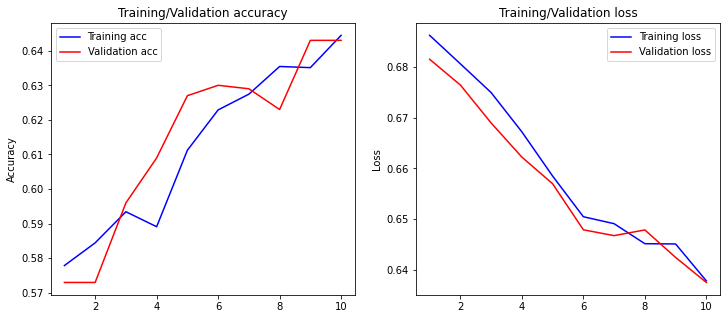

In [27]:
plot_history(history)

In [75]:
model.evaluate(X_test_pad,y_test)  

93/93 [==============================] - ETA: 40s - loss: 0.6331 - accuracy: 0.593 - ETA: 11s - loss: 0.6436 - accuracy: 0.609 - ETA: 10s - loss: 0.6497 - accuracy: 0.614 - ETA: 10s - loss: 0.6410 - accuracy: 0.625 - ETA: 10s - loss: 0.6375 - accuracy: 0.631 - ETA: 9s - loss: 0.6516 - accuracy: 0.640 - ETA: 9s - loss: 0.6469 - accuracy: 0.65 - ETA: 9s - loss: 0.6495 - accuracy: 0.65 - ETA: 9s - loss: 0.6506 - accuracy: 0.64 - ETA: 9s - loss: 0.6599 - accuracy: 0.63 - ETA: 8s - loss: 0.6594 - accuracy: 0.63 - ETA: 8s - loss: 0.6644 - accuracy: 0.62 - ETA: 8s - loss: 0.6786 - accuracy: 0.60 - ETA: 8s - loss: 0.6849 - accuracy: 0.59 - ETA: 8s - loss: 0.6875 - accuracy: 0.58 - ETA: 8s - loss: 0.6882 - accuracy: 0.58 - ETA: 8s - loss: 0.6897 - accuracy: 0.58 - ETA: 8s - loss: 0.6915 - accuracy: 0.58 - ETA: 8s - loss: 0.6928 - accuracy: 0.58 - ETA: 7s - loss: 0.6902 - accuracy: 0.59 - ETA: 7s - loss: 0.6902 - accuracy: 0.59 - ETA: 7s - loss: 0.6882 - accuracy: 0.60 - ETA: 7s - loss: 0.6858 -

[0.6723299622535706, 0.613598108291626]

## Performance Evaluation of model on test data set

In [76]:
y_test_predict = model.predict(X_test_pad)
y_predict = np.where(y_test_predict > 0.5,1,0)
y_pred = [item for sublist in y_predict for item in sublist]

In [77]:
from sklearn.metrics import classification_report

In [78]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.67      0.65      0.66      1719
     class 1       0.54      0.56      0.55      1252

    accuracy                           0.61      2971
   macro avg       0.61      0.61      0.61      2971
weighted avg       0.62      0.61      0.61      2971



## Error Analysis

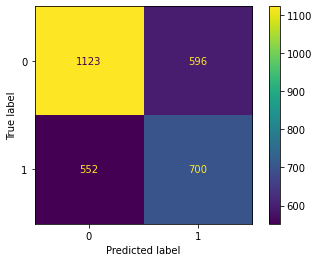

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred,labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [80]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


In [81]:
fpr = fp / (fp + tn)
print('False positive rate - ', fpr)
fnr = fn / (fn + tp)
print('False negative rate - ', fnr)

False positive rate -  0.3467132053519488
False negative rate -  0.44089456869009586


In [82]:
result_eval = pd.DataFrame({'Predicted' : y_pred, 'Actual' : y_test})

In [83]:
# Get 10 false positives indices to find their texts
fp_index = result_eval[(result_eval['Predicted'] == 1) & (result_eval['Actual'] == 0)].index.values[:5]

In [84]:
test.iloc[fp_index, :]

,id,text,HS,TR,AG,cleaned_tweets,tokens
3,31224,>Harasses women and calls them bitch and crabby >They block him >Plays the victim https://t.co/gmraGDtcQm,0,0,0,harasses woman call bitch crabby block play victim,"[harasses, woman, call, bitch, crabby, block, play, victim]"
4,31139,"Bitch you ain't gotta call my phone, matter fact all you hoes can leave me alone!! 💯",0,0,0,bitch ain't gotta call phone matter fact hoe leave alone 💯,"[bitch, ain't, gotta, call, phone, matter, fact, hoe, leave, alone, 💯]"
12,34138,He is a snake ass bitch. He is a fugly slut who shouldn't be trusted and I'm patiently waiting for him to be 18 cuz… https://t.co/NbezBfDPQ4,0,0,0,snake as bitch fugly slut trust i'm patiently wait cuz …,"[snake, as, bitch, fugly, slut, trust, i'm, patiently, wait, cuz, …]"
13,34165,"You seem like a hoe Ok bitch? Did I ever deny that? Nope, Next.",0,0,0,seem like hoe ok bitch ever deny nope next,"[seem, like, hoe, ok, bitch, ever, deny, nope, next]"
15,33150,happy bday to my big boobie bitch🎉❤️ily and im so sad i cant be there with u to celebrate but dw u hoe we'll party… https://t.co/MxNNWmSnZB,0,0,0,happy bday big boobie bitch 🎉 ❤ ️ily im sad cant u celebrate dw u hoe we'll party …,"[happy, bday, big, boobie, bitch, 🎉, ❤, ️ily, im, sad, cant, u, celebrate, dw, u, hoe, we'll, party, …]"


In [85]:
# Get 10 false negative indices to find their texts
fn_index = result_eval[(result_eval['Predicted'] == 0) & (result_eval['Actual'] == 1)].index.values[:5]

In [86]:
pd.set_option('display.max_colwidth', None)
test.iloc[fn_index, :]

,id,text,HS,TR,AG,cleaned_tweets,tokens
9,30072,@christianllamar @LindseyGrahamSC stop w 'we have to worry about the children' No we do not-many R >20yrs old Go home and make your country better or enter ours legally #NoDACA we can't afford them,1,0,0,stop w worry child not-many r yr old go home make country better enter legally #nodaca can't afford,"[stop, w, worry, child, not-many, r, yr, old, go, home, make, country, better, enter, legally, #nodaca, can't, afford]"
11,33818,"Im going to explode if I have to listen to these entitled, privileged cunts bitch for ONE MORE SECOND about their inconvenient FREE flights",1,0,0,im go explode listen entitle privileged cunt bitch one second inconvenient free flight,"[im, go, explode, listen, entitle, privileged, cunt, bitch, one, second, inconvenient, free, flight]"
17,32162,Argentina imported tons of Mestizos and they went from a first world country to another third world Latin American shithole. This is what's in store for America if we #AbolishICE. #BuildTheDamnWall #DeportThemAll #SupportICE #KAG,1,0,0,argentina import ton mestizos go first world country another third world latin american shithole what's store america #abolishice #buildthedamnwall #deportthemall #supportice #kag,"[argentina, import, ton, mestizos, go, first, world, country, another, third, world, latin, american, shithole, what's, store, america, #abolishice, #buildthedamnwall, #deportthemall, #supportice, #kag]"
26,33238,is PROOF that theyre more privleged. also my bitch mother wont bring my pizza rolls up here like the lazy cunt she is so brb.,1,1,0,proof theyre privleged also bitch mother wont bring pizza roll like lazy cunt brb,"[proof, theyre, privleged, also, bitch, mother, wont, bring, pizza, roll, like, lazy, cunt, brb]"
27,31004,Tell that bitch to pay me if she EVER tryna rape me,1,1,0,tell bitch pay ever tryna rape,"[tell, bitch, pay, ever, tryna, rape]"


## Train the model on the augmented data

This technique of data augmententation is done using the method described in  http://github.com/jasonwei20/eda_nlp

In [87]:
df_new_train = pd.read_csv("eda_train.txt",sep="\t",header=None,names = ['HS', 'text'])

In [88]:
df_new_train.shape

(90000, 2)

In [89]:
df_new_train.head(5)

,HS,text
0,1,hurray saving us in many ways potus realdonaldtrump lockthemup buildthewall enddaca boycottnfl
1,1,hurray saving us in so many ways potus realdonaldtrump lockthemup buildthewall boycottnfl boycottnike
2,1,hurray saving us in so many ways potus realdonaldtrump lockthemup buildthewall enddaca keep boycottnfl boycottnike
3,1,potus saving us in so many ways hurray realdonaldtrump lockthemup buildthewall enddaca boycottnfl boycottnike
4,1,hurray saving us in so many ways enddaca realdonaldtrump lockthemup buildthewall potus boycottnfl boycottnike


In [133]:
# shuffle the data set
df_new_train = df_new_train.sample(frac=1,axis=0).reset_index(drop=True)
# Pre-process training data
train_new = preprocess_data(df_new_train)

In [134]:
x_train = train_new.cleaned_tweets.values
y_train = df_new_train.HS.values

In [135]:
x_train.shape

(90000,)

In [136]:
# create the tokenizer
tokenizer_obj = Tokenizer()
# fit the tokenizer on the training input data
tokenizer_obj.fit_on_texts(x_train)

In [137]:
# Encode the tweets in the training dataset
X_train_tokens = tokenizer_obj.texts_to_sequences(x_train)
# Encode the tweets in the test dataset
X_test_tokens = tokenizer_obj.texts_to_sequences(x_test)
# Encode the tweets in the validation dataset
X_dev_tokens = tokenizer_obj.texts_to_sequences(x_val)

In [138]:
# Pad all tweets (training, test and validation) to the length of the longest review in the training dataset.
max_length = max([len(s.split()) for s in x_train])
X_train_pad = pad_sequences(X_train_tokens, maxlen = max_length, padding = 'post')
X_test_pad = pad_sequences(X_test_tokens, maxlen = max_length, padding = 'post')
X_dev_pad = pad_sequences(X_dev_tokens, maxlen = max_length, padding = 'post')

In [139]:
num_words = len(tokenizer_obj.word_index) + 1
model = Sequential()
model.add(Embedding(num_words,48))
model.add(Bidirectional(LSTM(320)))
model.add(Dropout(0.1))
#model.add(Dropout(0.5))
model.add(Dense(320, activation='sigmoid'))
model.add(Dropout(0.1))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate = 0.001))
  

In [140]:
history1 = model.fit(X_train_pad, y_train, batch_size = 9000,epochs = 10, verbose =2,
                          validation_data= (X_dev_pad, y_val),callbacks=[early_stopping])

Epoch 1/10
10/10 - 603s - loss: 0.6910 - accuracy: 0.5551 - val_loss: 0.6807 - val_accuracy: 0.5730
Epoch 2/10
10/10 - 709s - loss: 0.6633 - accuracy: 0.6048 - val_loss: 0.6714 - val_accuracy: 0.6090
Epoch 3/10
10/10 - 787s - loss: 0.5440 - accuracy: 0.7382 - val_loss: 0.6292 - val_accuracy: 0.6940
Epoch 4/10
10/10 - 793s - loss: 0.3566 - accuracy: 0.8478 - val_loss: 0.6096 - val_accuracy: 0.7000
Epoch 5/10
10/10 - 810s - loss: 0.2310 - accuracy: 0.9094 - val_loss: 0.8252 - val_accuracy: 0.6890
Epoch 6/10
10/10 - 869s - loss: 0.1512 - accuracy: 0.9421 - val_loss: 0.8532 - val_accuracy: 0.6940
Epoch 7/10
10/10 - 3113s - loss: 0.0945 - accuracy: 0.9673 - val_loss: 0.9908 - val_accuracy: 0.6800
Epoch 8/10
10/10 - 746s - loss: 0.0655 - accuracy: 0.9784 - val_loss: 1.2428 - val_accuracy: 0.6690
Epoch 9/10
10/10 - 831s - loss: 0.0474 - accuracy: 0.9849 - val_loss: 1.4068 - val_accuracy: 0.6740


In [141]:
model.evaluate(X_test_pad,y_test)  

93/93 [==============================] - ETA: 10s - loss: 3.2776 - accuracy: 0.468 - ETA: 9s - loss: 3.0019 - accuracy: 0.531 - ETA: 9s - loss: 3.0360 - accuracy: 0.54 - ETA: 9s - loss: 2.8908 - accuracy: 0.52 - ETA: 8s - loss: 2.8800 - accuracy: 0.53 - ETA: 8s - loss: 2.8199 - accuracy: 0.53 - ETA: 8s - loss: 2.8179 - accuracy: 0.53 - ETA: 8s - loss: 2.6185 - accuracy: 0.53 - ETA: 8s - loss: 2.6363 - accuracy: 0.52 - ETA: 8s - loss: 2.6333 - accuracy: 0.50 - ETA: 8s - loss: 2.6889 - accuracy: 0.51 - ETA: 8s - loss: 2.6992 - accuracy: 0.51 - ETA: 7s - loss: 2.7007 - accuracy: 0.51 - ETA: 7s - loss: 2.6504 - accuracy: 0.52 - ETA: 7s - loss: 2.5915 - accuracy: 0.53 - ETA: 7s - loss: 2.5561 - accuracy: 0.53 - ETA: 7s - loss: 2.5825 - accuracy: 0.53 - ETA: 7s - loss: 2.6046 - accuracy: 0.52 - ETA: 7s - loss: 2.6007 - accuracy: 0.53 - ETA: 7s - loss: 2.6095 - accuracy: 0.53 - ETA: 7s - loss: 2.5768 - accuracy: 0.53 - ETA: 7s - loss: 2.5560 - accuracy: 0.53 - ETA: 6s - loss: 2.5521 - accurac

[2.667123317718506, 0.5196903347969055]

In [142]:
y_test_predict = model.predict(X_test_pad)
y_predict = np.where(y_test_predict > 0.5,1,0)
y_pred = [item for sublist in y_predict for item in sublist]

In [143]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.71      0.28      0.41      1719
     class 1       0.46      0.84      0.60      1252

    accuracy                           0.52      2971
   macro avg       0.59      0.56      0.50      2971
weighted avg       0.61      0.52      0.49      2971



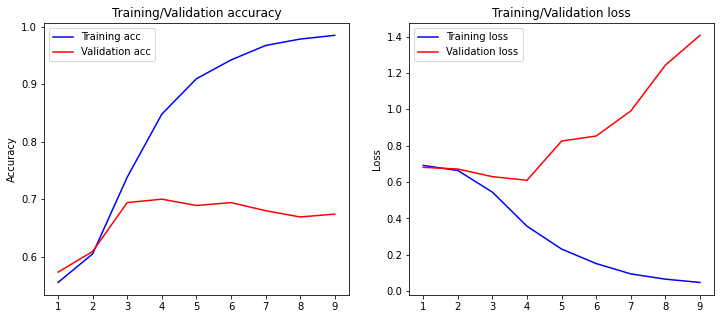

In [144]:
# Plot shows it clearly overfits training data and validataion loss is increasing which indicates to reduce 
# early stopping patience parameter
plot_history(history1)